# 1. Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split # only for split the dataset

# 2. Data (4 features, 3 classifications)

In [2]:
csv_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
col_names = ['Sepal_Length','Sepal_Width','Petal_Length','Petal_Width','Species']
iris_df =  pd.read_csv(csv_url, names = col_names)
iris_df.head()

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# 3. Pre-processing: one_hot_encode for categorial data (labels in classification problem)

In [3]:
### Categorical data to be converted to numeric data
labels = iris_df.Species.tolist()
unique_labels = np.unique(labels)

### map each specise to an integer
mapping = {}
for x in range(len(unique_labels)):
    mapping[unique_labels[x]] = x

one_hot_encode = []

for c in labels:
    arr = list(np.zeros(len(unique_labels), dtype = int))
    arr[mapping[c]] = 1
    one_hot_encode.append(arr)
    
iris_df['act_arr'] = one_hot_encode
print('label ', labels[0], ' is represented by ', one_hot_encode[0])
print('label ', labels[90], ' is represented by ', one_hot_encode[90])
print('label ', labels[-1], ' is represented by ', one_hot_encode[-1])

label  Iris-setosa  is represented by  [1, 0, 0]
label  Iris-versicolor  is represented by  [0, 1, 0]
label  Iris-virginica  is represented by  [0, 0, 1]


In [14]:
mapping

{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

In [4]:
iris_df['act_arr'] = one_hot_encode
iris_df

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species,act_arr
0,5.1,3.5,1.4,0.2,Iris-setosa,"[1, 0, 0]"
1,4.9,3.0,1.4,0.2,Iris-setosa,"[1, 0, 0]"
2,4.7,3.2,1.3,0.2,Iris-setosa,"[1, 0, 0]"
3,4.6,3.1,1.5,0.2,Iris-setosa,"[1, 0, 0]"
4,5.0,3.6,1.4,0.2,Iris-setosa,"[1, 0, 0]"
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica,"[0, 0, 1]"
146,6.3,2.5,5.0,1.9,Iris-virginica,"[0, 0, 1]"
147,6.5,3.0,5.2,2.0,Iris-virginica,"[0, 0, 1]"
148,6.2,3.4,5.4,2.3,Iris-virginica,"[0, 0, 1]"


# 4. Model Architecture

### This simple network has three layers (one input layer, one hidden layer with two nodes, one output layer)

In [5]:
n_features = 4
n_labels = 3

n_InputLayer = n_features
n_HiddenLayer = 2 
n_OutputLayer = n_labels

np.random.seed(7)
nnet_paras = {
    'Ws_InputLayer_HiddenLayer': np.random.uniform(-(1/np.sqrt(n_InputLayer)), 1/np.sqrt(n_InputLayer), size=(n_InputLayer, n_HiddenLayer)) ,
    'Bs_HiddenLayer': np.random.uniform(-(1/np.sqrt(n_HiddenLayer)), 1/np.sqrt(n_HiddenLayer), size=(n_HiddenLayer)),
    'Ws_HiddenLayer_OutputLayer': np.random.uniform(-(1/np.sqrt(n_HiddenLayer)), 1/np.sqrt(n_HiddenLayer), size=(n_HiddenLayer, n_OutputLayer)),
    'Bs_OutputLayer': np.random.uniform(-(1/np.sqrt(n_OutputLayer)), 1/np.sqrt(n_OutputLayer), size=(n_OutputLayer))
}

In [6]:
# initial parameter values
nnet_paras

{'Ws_InputLayer_HiddenLayer': array([[-0.42369171,  0.27991879],
        [-0.06159077,  0.22346518],
        [ 0.47798951,  0.03849587],
        [ 0.00112046, -0.42794887]]),
 'Bs_HiddenLayer': array([-3.27476735e-01, -1.66168926e-04]),
 'Ws_HiddenLayer_OutputLayer': array([[ 0.25346949,  0.42955186, -0.16837466],
        [-0.61385871, -0.29960737,  0.57925272]]),
 'Bs_OutputLayer': array([-0.33095409, -0.05528249,  0.49791382])}

## Forward Propagation
### helper functions

In [7]:
# activation function f in the hideen layer
def sigmoid(input):
    return 1 / (np.exp(-input) + 1)
# activation function g in the output layer
def softmax(inputs):
    outputs = []
    e_list = [np.exp(i) for i in inputs]
    sum_e = sum(e_list)
    for e in e_list:
        tmp = e/sum_e
        outputs.append(tmp)
    return outputs
# 'difference'
def cross_entropy(pred_arr, act_arr):
    idx = act_arr.argmax()
    return -np.log(pred_arr[idx])

In [8]:
def forward(X, nnet_paras, act_arr):
    nnet = {
        'act_idx': [],
        'pred':[],
        'N_input':[],
        'N_output':[],
        'CE':[]
    }
    # get parameters
    Ws_InputLayer_HiddenLayer = nnet_paras['Ws_InputLayer_HiddenLayer']
    Bs_HiddenLayer = nnet_paras['Bs_HiddenLayer']
    Ws_HiddenLayer_OutputLayer = nnet_paras['Ws_HiddenLayer_OutputLayer']
    Bs_OutputLayer = nnet_paras['Bs_OutputLayer']
    
    # Hidden layer inputs
    N_inputs = []
    for w, b in zip(Ws_InputLayer_HiddenLayer.T, Bs_HiddenLayer):
        N_input = sum(X*w) + b
        N_inputs.append(N_input)
        nnet['N_input'].append(N_input)
    # Hidden layer outputs
    N_outputs = [sigmoid(N_input) for N_input in N_inputs]
    nnet['N_output'] = N_outputs
    
    # Outputlayer inputs
    O_inputs = []
    for w, b in zip(Ws_HiddenLayer_OutputLayer.T, Bs_OutputLayer):
        O_input = sum(N_outputs*w) + b
        O_inputs.append(O_input)
    # Outputlayer outputs = Pred
    O_outputs = softmax(O_inputs)
    idx = np.argmax(act_arr)
    nnet['act_idx'] = idx
    nnet['pred'] = O_outputs
    
    # cross-entropy
    CE = cross_entropy(O_outputs, np.array(act_arr))
    nnet['CE'] = CE
    
    return nnet

## Backward Propagation
### helper functions

In [9]:
def pred_sample_total(idx_O, nnet_set):  
    derivative = 0
    for i in nnet_set:
        nnet = nnet_set[i]
        act_idx = nnet['act_idx']
        pred = nnet['pred'][idx_O]
        if act_idx == idx_O:
            pred = pred - 1
        derivative = derivative + pred
    return derivative


def pred_w_N_sample(idx_N, nnet, curr_para):
    idx_O = nnet['act_idx']
    pred_ = nnet['pred'][idx_O] - 1
    w = curr_para['Ws_HiddenLayer_OutputLayer'][idx_N][idx_O]
    N_input = nnet['N_input'][idx_N]
    N = derivative_sigmoid(N_input) 
    return pred_*w*N


def derivative_sigmoid(N_input):
    f = 1/(1+np.exp(-N_input))
    return f * (1 - f)

In [10]:
def backward(X_df, nnet_set, curr_para, lr):
    n_InputLayer = len(curr_para['Ws_InputLayer_HiddenLayer'])
    n_HiddenLayer = len(curr_para['Ws_HiddenLayer_OutputLayer']) 
    n_OutputLayer = len(curr_para['Bs_OutputLayer'])
    
    # adjust output layer b
    new_Bs_OutputLayer = []
    for O in range(n_OutputLayer):
        derivative = pred_sample_total(O, nnet_set)
        tmp = curr_para['Bs_OutputLayer'][O] - lr*derivative
        new_Bs_OutputLayer.append(tmp)
        
    # adjust weights between hidden layer and output layer
    new_Ws_HiddenLayer_OutputLayer = [] 
    for N in range(n_HiddenLayer):
        hidden_outputlayer = []
        for O in range(n_OutputLayer):
            derivative = 0
            for index,X in X_df.iterrows():
                nnet = nnet_set[index]
                N_output = nnet['N_output'][N]
                idx_O = nnet['act_idx']
                pred = nnet['pred'][idx_O]                
                if idx_O == O:
                    pred = pred - 1
                derivative = derivative + pred*N_output
            tmp = curr_para['Ws_HiddenLayer_OutputLayer'][N][O] - lr*derivative 
            hidden_outputlayer.append(tmp)
        new_Ws_HiddenLayer_OutputLayer.append(hidden_outputlayer)
    
    
    # adjust hidden layer b
    new_Bs_HiddenLayer = []
    for N in range(n_HiddenLayer):
        derivative = 0
        for index, X in X_df.iterrows():
            nnet = nnet_set[index]
            predwN = pred_w_N_sample(N, nnet, curr_para)
            derivative = derivative + predwN
        tmp = curr_para['Bs_HiddenLayer'][N] - lr*derivative
        new_Bs_HiddenLayer.append(tmp)
    
    # adjust weights between input layer and hidden layer
    new_Ws_InputLayer_HiddenLayer = []
    for I in range(n_InputLayer):
        inputlayer_HiddenLayer = []
        for N in range(n_HiddenLayer):
            derivative = 0
            for index, X in X_df.iterrows():
                nnet = nnet_set[index]
                predwN = pred_w_N_sample(N, nnet, curr_para)
                derivative = derivative + predwN*X[I]
            tmp = curr_para['Ws_InputLayer_HiddenLayer'][I][N] - lr*derivative
            inputlayer_HiddenLayer.append(tmp)
        new_Ws_InputLayer_HiddenLayer.append(inputlayer_HiddenLayer)
    # update
    curr_para['Ws_InputLayer_HiddenLayer'] = np.array(new_Ws_InputLayer_HiddenLayer)
    curr_para['Bs_HiddenLayer'] =  np.array(new_Bs_HiddenLayer)
    curr_para['Ws_HiddenLayer_OutputLayer'] =  np.array(new_Ws_HiddenLayer_OutputLayer)
    curr_para['Bs_OutputLayer'] =  np.array(new_Bs_OutputLayer) 
    
    return curr_para

# 5. Training model to get the optimal parameters

In [11]:
# train and test dataset
train, test = train_test_split(iris_df, test_size=0.2)

In [12]:
iter = 0
max_iter = 80

CE_total_list = []
while iter < max_iter:    
    # current net
    nnet_set = {}
    ### FORWARD
    CE_total = 0
    for index, row in train.iterrows():
        X = row.iloc[:-2].tolist()
        act_arr = row.iloc[-1]
        nnet = forward(X, nnet_paras, act_arr)
        CE_total = CE_total + nnet['CE']
        
        nnet_set[index] = nnet
    print('At iter-', iter, 'the loss is ', CE_total, end='. ', flush=True)
    CE_total_list.append(CE_total)
    
    ### BACKWARD
    nnet_paras = backward(train, nnet_set, nnet_paras, lr=0.005)
    
    ####
    iter += 1

At iter- 0 the loss is  174.64826862603908. At iter- 1 the loss is  155.31511415435367. At iter- 2 the loss is  144.34671509638758. At iter- 3 the loss is  138.77595924546227. At iter- 4 the loss is  135.78163001503387. At iter- 5 the loss is  133.92045294581467. At iter- 6 the loss is  132.6812689518622. At iter- 7 the loss is  131.8278587587348. At iter- 8 the loss is  131.21266701290023. At iter- 9 the loss is  130.73458633456124. At iter- 10 the loss is  130.3228345256791. At iter- 11 the loss is  129.9266409942647. At iter- 12 the loss is  129.5079674927264. At iter- 13 the loss is  129.03687974043476. At iter- 14 the loss is  128.4893906278874. At iter- 15 the loss is  127.84741147236431. At iter- 16 the loss is  127.09983659883709. At iter- 17 the loss is  126.24295794255255. At iter- 18 the loss is  125.27849787034599. At iter- 19 the loss is  124.20955788399786. At iter- 20 the loss is  123.03713749507432. At iter- 21 the loss is  121.75952540543716. At iter- 22 the loss is  1

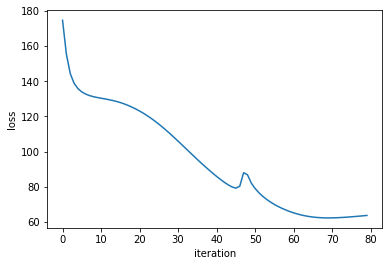

In [13]:
plt.plot(CE_total_list)

plt.xlabel("iteration")
plt.ylabel("loss")

plt.show()

In [15]:
# the optimal paramter values
nnet_paras

{'Ws_InputLayer_HiddenLayer': array([[-0.97310779, -0.86161539],
        [-0.33077889, -1.16087308],
        [ 0.06970534,  1.65688367],
        [-0.14174733,  0.56760584]]),
 'Bs_HiddenLayer': array([-0.41732183, -0.42186736]),
 'Ws_HiddenLayer_OutputLayer': array([[-1.16924473, -1.29012472, -2.4057132 ],
        [-7.53068762, -1.24876462,  1.65310123]]),
 'Bs_OutputLayer': array([ 1.40097079,  0.0228037 , -1.31209723])}

### The difference between the actual species and the predicted species is expected to decrease.

# 6. Test the adjusted model on the test dataset

## Prediction 

In [24]:
def prediction(X, nnet_paras, mapping=mapping):
    # get parameters
    Ws_InputLayer_HiddenLayer = nnet_paras['Ws_InputLayer_HiddenLayer']
    Bs_HiddenLayer = nnet_paras['Bs_HiddenLayer']
    Ws_HiddenLayer_OutputLayer = nnet_paras['Ws_HiddenLayer_OutputLayer']
    Bs_OutputLayer = nnet_paras['Bs_OutputLayer']
    
    # Hidden layer inputs
    N_inputs = []
    for w, b in zip(Ws_InputLayer_HiddenLayer.T, Bs_HiddenLayer):
        N_input = sum(X*w) + b
        N_inputs.append(N_input)
        nnet['N_input'].append(N_input)
    # Hidden layer outputs
    N_outputs = [sigmoid(N_input) for N_input in N_inputs]
    nnet['N_output'] = N_outputs
    
    # Outputlayer inputs
    O_inputs = []
    for w, b in zip(Ws_HiddenLayer_OutputLayer.T, Bs_OutputLayer):
        O_input = sum(N_outputs*w) + b
        O_inputs.append(O_input)
    # Outputlayer outputs = Pred
    O_outputs = softmax(O_inputs)
    pred_idx = np.argmax(O_outputs)
    # reverse the mapping
    res = dict((v,k) for k,v in mapping.items())
    
    return res[pred_idx]

In [25]:
pred_species_test = []
for index, row in test.iterrows():
    X = row.iloc[:-2].tolist()
    pred = prediction(X, nnet_paras)
    pred_species_test.append(pred)

test['pred_species'] = pred_species_test
test

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species,act_arr,pred_species
134,6.1,2.6,5.6,1.4,Iris-virginica,"[0, 0, 1]",Iris-virginica
110,6.5,3.2,5.1,2.0,Iris-virginica,"[0, 0, 1]",Iris-virginica
98,5.1,2.5,3.0,1.1,Iris-versicolor,"[0, 1, 0]",Iris-setosa
32,5.2,4.1,1.5,0.1,Iris-setosa,"[1, 0, 0]",Iris-setosa
55,5.7,2.8,4.5,1.3,Iris-versicolor,"[0, 1, 0]",Iris-versicolor
86,6.7,3.1,4.7,1.5,Iris-versicolor,"[0, 1, 0]",Iris-versicolor
140,6.7,3.1,5.6,2.4,Iris-virginica,"[0, 0, 1]",Iris-virginica
126,6.2,2.8,4.8,1.8,Iris-virginica,"[0, 0, 1]",Iris-virginica
85,6.0,3.4,4.5,1.6,Iris-versicolor,"[0, 1, 0]",Iris-versicolor
63,6.1,2.9,4.7,1.4,Iris-versicolor,"[0, 1, 0]",Iris-versicolor


## Meaasure the accuracy of this trained model
### measurement: 
$$\text{Accuracy}=\frac{\text{Numbers of correct predictions}}{\text{Numbers of total predictions made}}$$

In [29]:
def Accuracy(act, pred):
    correct_n = 0
    for i, j in zip(act, pred):  
        if i == j:
            correct_n += 1
    return correct_n/len(act)    

In [30]:
act = test['Species']
pred = test['pred_species']
acc = Accuracy(act, pred)
acc

0.9333333333333333

### This model can predict the species of the Iris flower with an accuracy of 93%.